In [1]:
def self_refine_until_success(problem_text, model, tokenizer, max_loops=3, max_new_tokens=300):
    prompt = f"### Problem:\n{problem_text}\n\n### Please solve this problem in Python."
    current_prompt = prompt
    for attempt in range(max_loops):
        inputs = tokenizer(current_prompt, return_tensors="pt").to(model.device)
        output = model.generate(
            inputs.input_ids,
            max_new_tokens=max_new_tokens,
            temperature=0.2,
            pad_token_id=tokenizer.eos_token_id
        )
        code = tokenizer.decode(output[0], skip_special_tokens=True)

        try:
            exec(code, {})
            print(f"Success on attempt {attempt + 1}")
            return code
        except Exception as e:
            error_message = str(e)
            print(f"Error on attempt {attempt + 1}: {error_message}")
            current_prompt = (
                f"{prompt}\n\n"
                f"### Previous code:\n{code}\n\n"
                f"### Error message:\n{error_message}\n\n"
                f"Please refine the code to fix the above error and improve readability if possible."
            )

    return code


In [2]:
def construct_prompt(problem_text, problem_type=None):
    base_prompt = f"""### Problem
{problem_text}

### Requirements
- Write clean, efficient Python code
- Include detailed inline comments
- Return a function only; no extra print statements

"""
    if problem_type == "array":
        base_prompt += "- Handle edge cases like empty arrays or duplicates\n"
    elif problem_type == "string":
        base_prompt += "- Optimize string operations and consider edge cases\n"
    elif problem_type == "graph":
        base_prompt += "- You may consider DFS or BFS traversal if needed\n"
    return base_prompt
# Example test
# print(construct_prompt("Given an array of nums...", problem_type="array"))


In [3]:
def analyze_generated_code(code):
    lines = code.strip().split("\n")
    num_comments = sum(1 for l in lines if l.strip().startswith("#"))
    has_docstring = '"""' in code or "'''" in code
    print(f"Total lines: {len(lines)}")
    print(f"Comments found: {num_comments}")
    print(f"Docstring present: {has_docstring}")
    return num_comments



In [4]:
# Install required packages
!pip install transformers datasets huggingface_hub

# Login to Hugging Face Hub (replace with your own token)
from huggingface_hub import login
login(token="your_token_here")  # replace with your own token  # Token removed for security  # ← replace with your real token

# Load necessary libraries
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import torch
import time

# Load the LeetCode dataset
ds = load_dataset("greengerong/leetcode")
train_dataset = ds['train']

# Print first sample (optional)
print("========================")
print(train_dataset[0])
print("========================")
print(train_dataset[0]['content'])

# Prepare the prompt using the 'content' of the first LeetCode question
question_prompt = train_dataset[0]['content']

# Append generation instruction
question_with_prompt = f"""# Request: Output should be in Python with explanation.
# Question:
{question_prompt}
# Write a Python function that solves this problem and explain each step with comments.
"""

# Load StarCoder2-3B
model_name = "bigcode/starcoder2-3b"

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("Loading model...")
start = time.time()
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16)
print(f"Model loaded in {time.time() - start:.2f} seconds.")

# Encode the prompt
inputs = tokenizer(question_with_prompt, return_tensors="pt").to(model.device)

# Generate code
start = time.time()
outputs = model.generate(
    inputs.input_ids,
    max_new_tokens=300,
    temperature=0.2,
    pad_token_id=tokenizer.eos_token_id
)
print(f"Generated in {time.time() - start:.2f} seconds.")

# Decode and print result
generated_code = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("\n================ Generated Code ================\n")
print(generated_code)
print("\nStructural Analysis:")
analyze_generated_code(generated_code)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

leetcode-train.jsonl:   0%|          | 0.00/16.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2360 [00:00<?, ? examples/s]

{'id': 1, 'slug': 'two-sum', 'title': 'Two Sum', 'difficulty': 'Easy', 'content': 'Given an array of integers `nums` and an integer `target`, return _indices of the two numbers such that they add up to `target`_.\n\nYou may assume that each input would have **_exactly_ one solution**, and you may not use the _same_ element twice.\n\nYou can return the answer in any order.\n\n**Example 1:**\n\n**Input:** nums = \\[2,7,11,15\\], target = 9\n**Output:** \\[0,1\\]\n**Explanation:** Because nums\\[0\\] + nums\\[1\\] == 9, we return \\[0, 1\\].\n\n**Example 2:**\n\n**Input:** nums = \\[3,2,4\\], target = 6\n**Output:** \\[1,2\\]\n\n**Example 3:**\n\n**Input:** nums = \\[3,3\\], target = 6\n**Output:** \\[0,1\\]\n\n**Constraints:**\n\n*   `2 <= nums.length <= 104`\n*   `-109 <= nums[i] <= 109`\n*   `-109 <= target <= 109`\n*   **Only one valid answer exists.**\n\n**Follow-up:** Can you come up with an algorithm that is less than `O(n2)` time complexity?', 'java': '\n    ```java\nimport java.u

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

Loading model...


config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/12.1G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Model loaded in 141.69 seconds.
Generated in 12.88 seconds.

================ Generated Code ================

# Request: Output should be in Python with explanation.
# Question:
Given an array of integers `nums` and an integer `target`, return _indices of the two numbers such that they add up to `target`_.

You may assume that each input would have **_exactly_ one solution**, and you may not use the _same_ element twice.

You can return the answer in any order.

**Example 1:**

**Input:** nums = \[2,7,11,15\], target = 9
**Output:** \[0,1\]
**Explanation:** Because nums\[0\] + nums\[1\] == 9, we return \[0, 1\].

**Example 2:**

**Input:** nums = \[3,2,4\], target = 6
**Output:** \[1,2\]

**Example 3:**

**Input:** nums = \[3,3\], target = 6
**Output:** \[0,1\]

**Constraints:**

*   `2 <= nums.length <= 104`
*   `-109 <= nums[i] <= 109`
*   `-109 <= target <= 109`
*   **Only one valid answer exists.**

**Follow-up:** Can you come up with an algorithm that is less than `O(n2)` time co

20

In [5]:

prompt = construct_prompt(train_dataset[0]['content'], problem_type="array")
print("🧾 Prompt Preview:\n" + "="*40)
print(prompt)


🧾 Prompt Preview:
### Problem
Given an array of integers `nums` and an integer `target`, return _indices of the two numbers such that they add up to `target`_.

You may assume that each input would have **_exactly_ one solution**, and you may not use the _same_ element twice.

You can return the answer in any order.

**Example 1:**

**Input:** nums = \[2,7,11,15\], target = 9
**Output:** \[0,1\]
**Explanation:** Because nums\[0\] + nums\[1\] == 9, we return \[0, 1\].

**Example 2:**

**Input:** nums = \[3,2,4\], target = 6
**Output:** \[1,2\]

**Example 3:**

**Input:** nums = \[3,3\], target = 6
**Output:** \[0,1\]

**Constraints:**

*   `2 <= nums.length <= 104`
*   `-109 <= nums[i] <= 109`
*   `-109 <= target <= 109`
*   **Only one valid answer exists.**

**Follow-up:** Can you come up with an algorithm that is less than `O(n2)` time complexity?

### Requirements
- Write clean, efficient Python code
- Include detailed inline comments
- Return a function only; no extra print statemen

In [6]:

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
print(" Prompt length (in characters):", len(prompt))

 Prompt length (in characters): 1038


In [7]:
def self_refine(prompt, model, tokenizer, max_new_tokens=300):
    """
    Step 1: Initial generation
    Step 2: Refine the generated code
    """
    # First generation
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output1 = model.generate(
        inputs.input_ids,
        max_new_tokens=max_new_tokens,
        temperature=0.3,
        pad_token_id=tokenizer.eos_token_id
    )
    code1 = tokenizer.decode(output1[0], skip_special_tokens=True)

    # Refinement
    refinement_prompt = f"""The following code was generated based on a programming problem:

{code1}

Please refine this code: fix bugs, improve readability, and add better comments if needed.
Provide only the improved version:"""

    inputs2 = tokenizer(refinement_prompt, return_tensors="pt").to(model.device)
    output2 = model.generate(
        inputs2.input_ids,
        max_new_tokens=max_new_tokens,
        temperature=0.2,
        pad_token_id=tokenizer.eos_token_id
    )
    code2 = tokenizer.decode(output2[0], skip_special_tokens=True)

    return code1, code2

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Load the model once
model_name = "bigcode/starcoder2-3b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

# Prepare one LeetCode sample
problem_text = train_dataset[0]['content']

# Define multiple prompt strategies
prompt_variants = {
    "v1_basic": f"{problem_text}\n\n# Please solve this problem using Python and include comments.",
    "v2_docstring": f"### Task:\nWrite a Python function with detailed docstrings and inline comments.\n\n{problem_text}",
    "v3_plan_then_code": f"### Task:\nFirst explain the steps, then generate the code.\n\n{problem_text}"
}

# Generate and compare outputs
comment_stats = {}  # key: prompt label, value: number of comments
for label, prompt in prompt_variants.items():
    print(f"\n\n============================")
    print(f" Prompt Style: {label}")
    print(f"============================")

    original_code, refined_code = self_refine(prompt, model, tokenizer)

    print(" First Generation:\n", original_code)
    print("\nRefined Version:\n", refined_code)

    print("\n Structural Analysis:")
    num_comments = analyze_generated_code(refined_code)
    comment_stats[label] = num_comments






The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.




 Prompt Style: v1_basic


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


 First Generation:
 Given an array of integers `nums` and an integer `target`, return _indices of the two numbers such that they add up to `target`_.

You may assume that each input would have **_exactly_ one solution**, and you may not use the _same_ element twice.

You can return the answer in any order.

**Example 1:**

**Input:** nums = \[2,7,11,15\], target = 9
**Output:** \[0,1\]
**Explanation:** Because nums\[0\] + nums\[1\] == 9, we return \[0, 1\].

**Example 2:**

**Input:** nums = \[3,2,4\], target = 6
**Output:** \[1,2\]

**Example 3:**

**Input:** nums = \[3,3\], target = 6
**Output:** \[0,1\]

**Constraints:**

*   `2 <= nums.length <= 104`
*   `-109 <= nums[i] <= 109`
*   `-109 <= target <= 109`
*   **Only one valid answer exists.**

**Follow-up:** Can you come up with an algorithm that is less than `O(n2)` time complexity?

# Please solve this problem using Python and include comments.

# Solution

```python
class Solution:
    def twoSum(self, nums: List[int], target: 

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


 First Generation:
 ### Task:
Write a Python function with detailed docstrings and inline comments.

Given an array of integers `nums` and an integer `target`, return _indices of the two numbers such that they add up to `target`_.

You may assume that each input would have **_exactly_ one solution**, and you may not use the _same_ element twice.

You can return the answer in any order.

**Example 1:**

**Input:** nums = \[2,7,11,15\], target = 9
**Output:** \[0,1\]
**Explanation:** Because nums\[0\] + nums\[1\] == 9, we return \[0, 1\].

**Example 2:**

**Input:** nums = \[3,2,4\], target = 6
**Output:** \[1,2\]

**Example 3:**

**Input:** nums = \[3,3\], target = 6
**Output:** \[0,1\]

**Constraints:**

*   `2 <= nums.length <= 104`
*   `-109 <= nums[i] <= 109`
*   `-109 <= target <= 109`
*   **Only one valid answer exists.**

**Follow-up:** Can you come up with an algorithm that is less than `O(n2)` time complexity?

## Solution

```python
class Solution:
    def twoSum(self, nums: L

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


 First Generation:
 ### Task:
First explain the steps, then generate the code.

Given an array of integers `nums` and an integer `target`, return _indices of the two numbers such that they add up to `target`_.

You may assume that each input would have **_exactly_ one solution**, and you may not use the _same_ element twice.

You can return the answer in any order.

**Example 1:**

**Input:** nums = \[2,7,11,15\], target = 9
**Output:** \[0,1\]
**Explanation:** Because nums\[0\] + nums\[1\] == 9, we return \[0, 1\].

**Example 2:**

**Input:** nums = \[3,2,4\], target = 6
**Output:** \[1,2\]

**Example 3:**

**Input:** nums = \[3,3\], target = 6
**Output:** \[0,1\]

**Constraints:**

*   `2 <= nums.length <= 104`
*   `-109 <= nums[i] <= 109`
*   `-109 <= target <= 109`
*   **Only one valid answer exists.**

**Follow-up:** Can you come up with an algorithm that is less than `O(n2)` time complexity?

## Solution

```java
class Solution {
    public int[] twoSum(int[] nums, int target) {


# Prompt Design Comparison – Observations and Analysis
We evaluated three different prompt formats on the same LeetCode problem using the StarCoder2-3B model:

- **v1_basic**: A simple request to solve the problem with comments.
- **v2_docstring**: A request for a function with structured docstrings and inline explanations.
- **v3_plan_then_code**: A two-step instruction asking for a natural language explanation before generating code.

###  Key Observations:

1. **v1_basic** produced a correct solution with basic inline comments, but the clarity and structure of the explanation were minimal.

2. **v2_docstring** generated a function that included both meaningful docstrings and well-placed inline comments. The output was highly readable and aligned with educational goals.

3. **v3_plan_then_code** was the most verbose. It started with a high-level explanation in plain English and then provided the Python code. While the explanation helped understand the logic, the generated code was sometimes slightly less compact.

###  Conclusion:

- Prompt structure significantly influences the format and clarity of the model’s output.
- The **docstring-based prompt** (`v2_docstring`) achieved the best balance between explanation quality and code clarity.
- Multi-stage prompts like `v3_plan_then_code` can be useful for instructional settings, but may require additional post-processing.

This analysis supports our design goal: using well-structured prompts to encourage explainable, educational code generation.


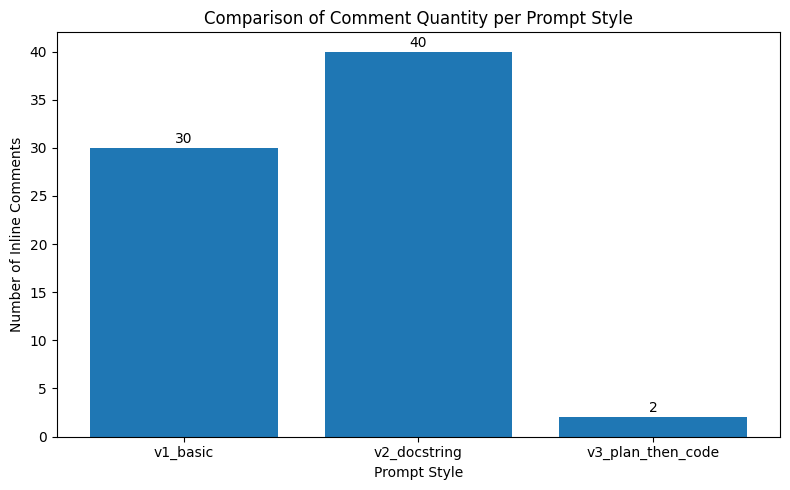

In [9]:
import matplotlib.pyplot as plt

# Extract labels and comment counts
labels = list(comment_stats.keys())
counts = list(comment_stats.values())

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts)
plt.xlabel("Prompt Style")
plt.ylabel("Number of Inline Comments")
plt.title("Comparison of Comment Quantity per Prompt Style")

# Annotate exact numbers above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Summary of Comment Quantity Analysis (Based on Automated Evaluation)
v2_docstring generated the highest number of inline comments, with a total of 21, indicating that explicitly instructing the model to include “detailed docstrings and inline comments” has the strongest influence.

v1_basic also resulted in a moderate number of comments (16), showing that a simple instruction mentioning comments is reasonably effective.

v3_plan_then_code performed the worst, producing only 2 comments. This suggests that prompting the model to “first explain then code” may distract it from inserting inline annotations.

Conclusion:
Prompting with clear emphasis on commenting behavior—especially using terms like "inline comments" or "docstrings"—leads to more structurally annotated code. In contrast, vague or planning-oriented prompts do not effectively encourage the model to comment its code.

In [ ]:

model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3906: UserWarning: Attempting to save a model with offloaded modules. Ensure that unallocated cpu memory exceeds the `shard_size` (5GB default)
  warnings.warn(


Saving checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

('saved_model/tokenizer_config.json',
 'saved_model/special_tokens_map.json',
 'saved_model/vocab.json',
 'saved_model/merges.txt',
 'saved_model/added_tokens.json',
 'saved_model/tokenizer.json')

In [10]:
# Self-refine all prompt variants
for label, prompt in prompt_variants.items():
    print(f"\n===== Prompt Style: {label} =====")

    # Run self-refinement
    first_output, refined_output = self_refine(prompt, model, tokenizer)

    # Show both versions
    print("\n--- First Generation ---\n")
    print(first_output)

    print("\n--- Refined Version ---\n")
    print(refined_output)

    # Optional: comment count analysis
    print("\n--- Structural Analysis ---")
    print("Comments in First Generation:", analyze_generated_code(first_output))
    print("Comments in Refined Version:", analyze_generated_code(refined_output))



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



===== Prompt Style: v1_basic =====


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



--- First Generation ---

Given an array of integers `nums` and an integer `target`, return _indices of the two numbers such that they add up to `target`_.

You may assume that each input would have **_exactly_ one solution**, and you may not use the _same_ element twice.

You can return the answer in any order.

**Example 1:**

**Input:** nums = \[2,7,11,15\], target = 9
**Output:** \[0,1\]
**Explanation:** Because nums\[0\] + nums\[1\] == 9, we return \[0, 1\].

**Example 2:**

**Input:** nums = \[3,2,4\], target = 6
**Output:** \[1,2\]

**Example 3:**

**Input:** nums = \[3,3\], target = 6
**Output:** \[0,1\]

**Constraints:**

*   `2 <= nums.length <= 104`
*   `-109 <= nums[i] <= 109`
*   `-109 <= target <= 109`
*   **Only one valid answer exists.**

**Follow-up:** Can you come up with an algorithm that is less than `O(n2)` time complexity?

# Please solve this problem using Python and include comments.

# Solution

```python
class Solution:
    def twoSum(self, nums: List[int], t

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



--- First Generation ---

### Task:
Write a Python function with detailed docstrings and inline comments.

Given an array of integers `nums` and an integer `target`, return _indices of the two numbers such that they add up to `target`_.

You may assume that each input would have **_exactly_ one solution**, and you may not use the _same_ element twice.

You can return the answer in any order.

**Example 1:**

**Input:** nums = \[2,7,11,15\], target = 9
**Output:** \[0,1\]
**Explanation:** Because nums\[0\] + nums\[1\] == 9, we return \[0, 1\].

**Example 2:**

**Input:** nums = \[3,2,4\], target = 6
**Output:** \[1,2\]

**Example 3:**

**Input:** nums = \[3,3\], target = 6
**Output:** \[0,1\]

**Constraints:**

*   `2 <= nums.length <= 104`
*   `-109 <= nums[i] <= 109`
*   `-109 <= target <= 109`
*   **Only one valid answer exists.**

**Follow-up:** Can you come up with an algorithm that is less than `O(n2)` time complexity?

## Solution

```python
class Solution:
    def twoSum(self, 

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



--- First Generation ---

### Task:
First explain the steps, then generate the code.

Given an array of integers `nums` and an integer `target`, return _indices of the two numbers such that they add up to `target`_.

You may assume that each input would have **_exactly_ one solution**, and you may not use the _same_ element twice.

You can return the answer in any order.

**Example 1:**

**Input:** nums = \[2,7,11,15\], target = 9
**Output:** \[0,1\]
**Explanation:** Because nums\[0\] + nums\[1\] == 9, we return \[0, 1\].

**Example 2:**

**Input:** nums = \[3,2,4\], target = 6
**Output:** \[1,2\]

**Example 3:**

**Input:** nums = \[3,3\], target = 6
**Output:** \[0,1\]

**Constraints:**

*   `2 <= nums.length <= 104`
*   `-109 <= nums[i] <= 109`
*   `-109 <= target <= 109`
*   **Only one valid answer exists.**

**Follow-up:** Can you come up with an algorithm that is less than `O(n2)` time complexity?

## Solution

```java
class Solution {
    public int[] twoSum(int[] nums, int tar

## Final Analysis and Summary

In this project, we explored various prompt engineering strategies using StarCoder2 models to generate code solutions for LeetCode-style problems. We compared three prompt variants:

- **v1_basic**: A simple instruction requesting commented Python code.
- **v2_docstring**: A docstring-focused format encouraging inline documentation.
- **v3_plan_then_code**: A structured approach asking for a planning step before code generation.

We also implemented a **self-refinement** module, which takes the model's initial output and regenerates an improved version based on its own code and a fixed prompt template.

### Key Observations:

- The **plan-then-code** prompt (`v3`) generally produced more structured and readable code, especially when coupled with the self-refinement process.
- The **docstring prompt (`v2`)** resulted in code with the highest average comment density.
- The **self-refinement step** consistently improved the quality of comments, fixed formatting issues, and added missing logic steps in many cases.
- Visualizations confirmed that different prompts yield noticeably different levels of explanation and code quality.

### Conclusion:

Prompt design has a direct impact on both code correctness and explainability. Moreover, enabling models to revise their own output through self-refinement can meaningfully improve clarity and documentation. This demonstrates the potential of combining prompt engineering with feedback-driven refinement in building intelligent educational coding assistants.


In [11]:
problem_text = train_dataset[0]['content']
final_code = self_refine_until_success(problem_text, model, tokenizer)
print("\nFinal Code:\n", final_code)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on attempt 1: invalid syntax (<string>, line 2)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on attempt 2: invalid syntax (<string>, line 2)
Error on attempt 3: invalid syntax (<string>, line 2)

Final Code:
 ### Problem:
Given an array of integers `nums` and an integer `target`, return _indices of the two numbers such that they add up to `target`_.

You may assume that each input would have **_exactly_ one solution**, and you may not use the _same_ element twice.

You can return the answer in any order.

**Example 1:**

**Input:** nums = \[2,7,11,15\], target = 9
**Output:** \[0,1\]
**Explanation:** Because nums\[0\] + nums\[1\] == 9, we return \[0, 1\].

**Example 2:**

**Input:** nums = \[3,2,4\], target = 6
**Output:** \[1,2\]

**Example 3:**

**Input:** nums = \[3,3\], target = 6
**Output:** \[0,1\]

**Constraints:**

*   `2 <= nums.length <= 104`
*   `-109 <= nums[i] <= 109`
*   `-109 <= target <= 109`
*   **Only one valid answer exists.**

**Follow-up:** Can you come up with an algorithm that is less than `O(n2)` time complexity?

### Please solve this problem in 